In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.optimize import least_squares as lsq
import random
random.seed(4321)
np.random.seed(1234)

In [2]:
PolRel = pd.read_excel("Seshat_PolityRelationData.xlsx")
Data = pd.read_csv("Seshat Data.csv")
Parameters_and_Times = np.loadtxt("Parameters_and_Times.txt")
RelTimeDF = pd.read_csv("RelTime_TimeSeries_SPC1.csv", index_col = 0)
RelTimeCCDF = pd.read_csv("RelTime_TimeSeries_CC.csv")
Parameters = Parameters_and_Times[:4]
Times = Parameters_and_Times[4:]
T = 5000

In [3]:
def f(x, a, b, c, d):
    # the logistic function in its most general shape, scaled by T=5000
    return a / (1. + np.exp(-c * (x - d))) + b

In [4]:
del RelTimeCCDF["Unnamed: 0"]

In [5]:
set(Data["NGA"]).issubset(set(PolRel["NGA"]))

True

In [6]:
# Discard superfluous NGAs
SubsetNGA = np.array(PolRel["NGA"].isin(set(Data["NGA"])))
PolRel = PolRel.iloc[SubsetNGA]


In [7]:
PolRel.head(50)

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN
18,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
19,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland I,NaN,NaN,NaN
20,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
21,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland II,NaN,NaN,NaN
22,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN


In [8]:
for i in list(set(PolRel["Dupl"])):
    print(i,sum(PolRel["Dupl"] == i))

n 596
y 103


In [9]:
# relationship to preceding (quasi)polity

for v in list(set(PolRel["Variable"])):
    print(v, sum(PolRel["Variable"]==v))

# Logical for Variable is the relationship
VR = PolRel["Variable"] == "relationship to preceding (quasi)polity"

Previous = PolRel.loc[np.logical_not(VR)]
Relationships = PolRel.loc[VR]

relationship to preceding (quasi)polity 335
succeeding (quasi)polity 364


In [10]:
Previous.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN
19,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,succeeding (quasi)polity,Cahokia - Late Woodland I,NaN,NaN,NaN


In [11]:
Relationships.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
18,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
20,Cahokia,USMisMW,Cahokia - Middle Woodland,-150.0,300.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
22,Cahokia,USMisRo,Cahokia - Late Woodland I,300.0,450.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN
23,Cahokia,USMisMu,Cahokia - Late Woodland II,450.0,600.0,n,General variables,relationship to preceding (quasi)polity,Continuity,NaN,NaN,NaN


In [12]:
for val in list(set(Relationships["Value.From"])):
    print(val, sum(Relationships["Value.From"]==val) )
                

continunity 4
suspected unknown 2
not applicable 2
contination 1
Continuation 1
replacement 1
Continuity 9
population migration 13
continuity 228
vassalage 1
continuation 7
indigenous revolt 1
cultural assimilation 25
elite migration 40


In [13]:
Relationships["Value.From"].replace("Continuation", "continuity", inplace = True)
Relationships["Value.From"].replace("continuation", "continuity", inplace = True)
Relationships["Value.From"].replace("continunity", "continuity", inplace = True)
Relationships["Value.From"].replace("contination", "continuity", inplace = True)
Relationships["Value.From"].replace("Continuity", "continuity", inplace = True)

                
for val in list(set(Relationships["Value.From"])):
    if val != "continuity":
        Relationships["Value.From"].replace(val, "discontinuity", inplace = True)

for val in list(set(Relationships["Value.From"])):
    print(val, sum(Relationships["Value.From"]==val) )    

discontinuity 85
continuity 250


C:\Users\Tobias\anaconda3\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [14]:
print(Relationships)

                      NGA    PolID               Longform.Name  Polity.Start  \
15      Big Island Hawaii  Hawaii2                   Hawaii II        1200.0   
18                Cahokia  USMisEW    Cahokia - Early Woodland        -600.0   
20                Cahokia  USMisMW   Cahokia - Middle Woodland        -150.0   
22                Cahokia  USMisRo   Cahokia - Late Woodland I         300.0   
23                Cahokia  USMisMu  Cahokia - Late Woodland II         450.0   
..                    ...      ...                         ...           ...   
849      Valley of Oaxaca  MxAlb3B     Monte Alban IIIB and IV         500.0   
852      Valley of Oaxaca  EsHabsb            Spanish Empire I        1469.0   
858  Yemeni Coastal Plain  YeQasmi     Yemen - Qasimid Dynasty        1637.0   
861  Yemeni Coastal Plain  TrOttm4          Ottoman Empire III        1683.0   
862  Yemeni Coastal Plain  YeOttoL  Ottoman Empire Late Period        1873.0   

     Polity.End Dupl            Section

In [15]:
PolRel.loc[PolRel["Dupl"] == "y"].iloc[51:100]

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
546,Paris Basin,ItRomPr,Roman Empire - Principate,-31.0,284.0,y,General variables,succeeding (quasi)polity,Roman Empire - Dominate,NaN,NaN,NaN
547,Paris Basin,ItRomPr,Roman Empire - Principate,-31.0,284.0,y,General variables,succeeding (quasi)polity,Roman Empire - Dominate,NaN,NaN,NaN
548,Paris Basin,ItRomPr,Roman Empire - Principate,-31.0,284.0,y,General variables,succeeding (quasi)polity,Roman Empire - Dominate,NaN,NaN,NaN
549,Paris Basin,ItRomPr,Roman Empire - Principate,-31.0,284.0,y,General variables,succeeding (quasi)polity,Roman Empire - Dominate,NaN,NaN,NaN
550,Paris Basin,TrRomDm,Roman Empire - Dominate,285.0,394.0,y,General variables,succeeding (quasi)polity,Western Roman Empire - Late Antiquity,NaN,NaN,NaN
551,Paris Basin,TrRomDm,Roman Empire - Dominate,285.0,394.0,y,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
581,Sogdiana,IrAchae,Achaemenid Empire,-550.0,-331.0,y,General variables,succeeding (quasi)polity,Macedonian Empire,NaN,NaN,NaN
582,Sogdiana,IrAchae,Achaemenid Empire,-550.0,-331.0,y,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
583,Sogdiana,IrSeleu,Seleucid Empire,-312.0,-63.0,y,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
584,Sogdiana,IrSeleu,Seleucid Empire,-312.0,-63.0,y,General variables,succeeding (quasi)polity,Parthian Empire I,NaN,NaN,NaN


In [16]:
for n in list(set(PolRel["NGA"])):
    print(PolRel.loc[PolRel["NGA"]==n])

             NGA    PolID        Longform.Name  Polity.Start  Polity.End Dupl  \
60  Central Java  IdCJBun  Java - Buni Culture        -400.0       500.0    n   
61  Central Java  IdKalin     Kalingga Kingdom         500.0       732.0    n   
62  Central Java  IdMedng       Medang Kingdom         732.0      1019.0    n   
63  Central Java  IdMedng       Medang Kingdom         732.0      1019.0    n   
64  Central Java  IdKedir       Kediri Kingdom        1049.0      1222.0    n   
65  Central Java  IdKedir       Kediri Kingdom        1049.0      1222.0    n   
66  Central Java  IdMajap    Majapahit Kingdom        1292.0      1518.0    n   
67  Central Java  IdMajap    Majapahit Kingdom        1292.0      1518.0    n   
68  Central Java  IdMatrm    Mataram Sultanate        1568.0      1703.0    n   

              Section                                 Variable  \
60  General variables                 succeeding (quasi)polity   
61  General variables                 succeeding (quasi)p

16            NaN  
                            NGA    PolID       Longform.Name  Polity.Start  \
413  Middle Yellow River Valley  CnYngsh            Yangshao       -5000.0   
414  Middle Yellow River Valley  CnLngsh            Longshan       -3000.0   
415  Middle Yellow River Valley  CnLngsh            Longshan       -3000.0   
416  Middle Yellow River Valley  CnErlit             Erlitou       -1850.0   
417  Middle Yellow River Valley  CnErlit             Erlitou       -1850.0   
418  Middle Yellow River Valley  CnErlig            Erligang       -1650.0   
419  Middle Yellow River Valley  CnErlig            Erligang       -1650.0   
420  Middle Yellow River Valley  CnShang          Late Shang       -1250.0   
421  Middle Yellow River Valley  CnShang          Late Shang       -1250.0   
422  Middle Yellow River Valley  CnWZhou        Western Zhou       -1122.0   
423  Middle Yellow River Valley  CnWZhou        Western Zhou       -1122.0   
424  Middle Yellow River Valley  CnJinSA    

456              NaN            NaN  
                    NGA    PolID                    Longform.Name  \
457  Niger Inland Delta  MlJeJe1                     Jenne-jeno I   
458  Niger Inland Delta  MlJeJe1                     Jenne-jeno I   
459  Niger Inland Delta  MlJeJe2                    Jenne-jeno II   
460  Niger Inland Delta  MlJeJe2                    Jenne-jeno II   
461  Niger Inland Delta  MlJeJe3                   Jenne-jeno III   
462  Niger Inland Delta  MlJeJe3                   Jenne-jeno III   
463  Niger Inland Delta  MrWagdM             Middle Wagadu Empire   
464  Niger Inland Delta  MrWagdM             Middle Wagadu Empire   
465  Niger Inland Delta  MlJeJe4                    Jenne-jeno IV   
466  Niger Inland Delta  MlJeJe4                    Jenne-jeno IV   
467  Niger Inland Delta  MrWagdL              Later Wagadu Empire   
468  Niger Inland Delta  MrWagdL              Later Wagadu Empire   
469  Niger Inland Delta  MlMali*                      Mali Empire

514       NaN              NaN            NaN  
                      NGA    PolID          Longform.Name  Polity.Start  \
613  Southern China Hills  CnHQngL      Hmong - Late Qing        1701.0   
614  Southern China Hills  CnHQngL      Hmong - Late Qing        1701.0   
615  Southern China Hills  CnHChin  Hmong - Early Chinese        1895.0   
616  Southern China Hills  CnHChin  Hmong - Early Chinese        1895.0   

     Polity.End Dupl            Section  \
613      1895.0    n  General variables   
614      1895.0    n  General variables   
615      1941.0    n  General variables   
616      1941.0    n  General variables   

                                    Variable                 Value.From  \
613                 succeeding (quasi)polity      Hmong - Early Chinese   
614  relationship to preceding (quasi)polity                 continuity   
615  relationship to preceding (quasi)polity                 continuity   
616                 succeeding (quasi)polity  Peoples Republ

In [17]:
CleanRel = pd.concat((Previous,Relationships), sort=False).sort_index()

In [18]:
CleanRel.head()

,NGA,PolID,Longform.Name,Polity.Start,Polity.End,Dupl,Section,Variable,Value.From,Value.To,Value.Date.From,Value.Date.To
13,Big Island Hawaii,Hawaii1,Hawaii I,1000.0,1200.0,n,General variables,succeeding (quasi)polity,Hawaii II,NaN,NaN,NaN
14,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,succeeding (quasi)polity,Hawaii III,NaN,NaN,NaN
15,Big Island Hawaii,Hawaii2,Hawaii II,1200.0,1580.0,n,General variables,relationship to preceding (quasi)polity,continuity,NaN,NaN,NaN
16,Big Island Hawaii,Hawaii3,Hawaii III,1580.0,1778.0,n,General variables,succeeding (quasi)polity,Kingdom of Hawaii - Kamehameha Period,NaN,NaN,NaN
17,Cahokia,USMisEW,Cahokia - Early Woodland,-600.0,-150.0,n,General variables,succeeding (quasi)polity,Cahokia - Middle Woodland,NaN,NaN,NaN


In [19]:
TimeZero = pd.read_csv("TimeZero.csv")
TimeZero.head()

,Unnamed: 0,Orkhon Valley,Ghanaian Coast,Susiana,Niger Inland Delta,Central Java,Cambodian Basin,Sogdiana,Konya Plain,Upper Egypt,Iceland,Middle Yellow River Valley,Yemeni Coastal Plain,Cuzco,Paris Basin,Kansai,Latium,Kachi Plain,Deccan
0,T0,500,1800,-3700,1000,800,300,-500,-2000,-3100,1300,-1800,400,1400,-200,400,-700,-2500,-300


In [20]:

# Again Discard superfluous NGAs
SubsetNGA_2 = np.array(Relationships["NGA"].isin(set(TimeZero.columns)))
Relationships = Relationships.iloc[SubsetNGA_2]

set(Relationships["NGA"]).issubset( set(TimeZero.columns))


True

In [21]:
Relationships["Polity.End.Scaled"] = 0

# iterate over all rows in the DF
for i in range(Relationships.shape[0]):
    n = Relationships["NGA"].iloc[i]
    
    # for this NGA: read its Time_Zero from the TimeZero.csv
    T_zero = TimeZero[n]
    # Shift the time accordingly
    Relationships["Polity.End.Scaled"].iloc[i] = Relationships["Polity.End"].iloc[i] - T_zero
    

C:\Users\Tobias\anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


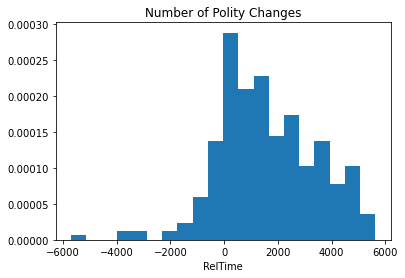

In [22]:
plt.hist(Relationships["Polity.End.Scaled"], bins =20, density = True)
plt.title("Number of Polity Changes")
plt.xlabel("RelTime")
plt.show()

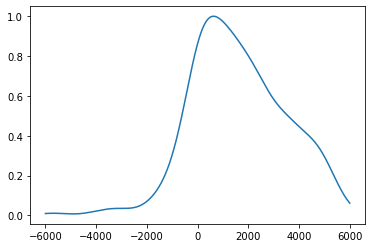

In [23]:
from scipy.stats import gaussian_kde
KDE = gaussian_kde(Relationships["Polity.End.Scaled"])
time_range = np.arange(-6000,6000,10)
KDE_t = KDE(time_range)
plt.plot(time_range, KDE_t / max(KDE_t))
plt.show()

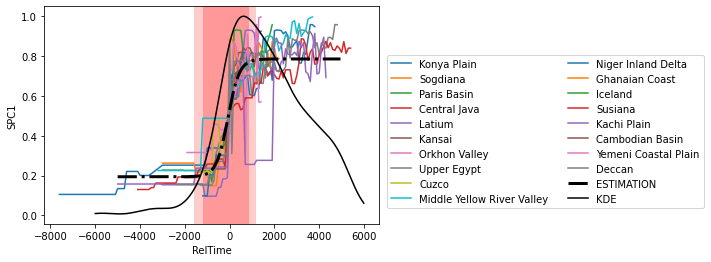

In [24]:
# Time Series Data fpr Reltime vs. SPC1
for N in list(set(RelTimeDF["NGA"])):
    DF = RelTimeDF[RelTimeDF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    
# Interpolation
x_show = np.arange(-1,1,0.01)    
y_hat = f(x_show, Parameters[0], Parameters[1], Parameters[2], Parameters[3])
plt.plot(x_show*T, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # scaled by T
plt.ylabel("SPC1")
plt.xlabel("RelTime")

# Denote the Regions of fast growth
plt.axvspan(Times[1], Times[2], facecolor='r', alpha=0.4)
plt.axvspan(Times[2], Times[3], facecolor='r', alpha=0.2)
plt.axvspan(Times[0], Times[1], facecolor='r', alpha=0.2)

# KDE of the polity changes
plt.plot(time_range, KDE_t / max(KDE_t), c="k", label="KDE")

plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)


plt.show()

## Normalise the Number of Polity Changes

Divide it by the number of existing polities at RelTime T, because if there are only few polities at an early time, we would also only expect few possible polity changes.

In [25]:
T_min, T_max = min(RelTimeDF["RelTime"]), max(RelTimeDF["RelTime"])

In [26]:
NumberPol = pd.DataFrame(columns=["RelTime", "NumberPol"])
for t in np.arange(T_min, T_max+100, 100):
    #print(t)
    #print(sum(RelTimeDF["RelTime"]==t))
    NumberPol = pd.concat([NumberPol,
                         pd.DataFrame({"RelTime": [t],
                                      "NumberPol": [sum(RelTimeDF["RelTime"]==t)]})])
NumberPol

,RelTime,NumberPol
0,-7600,1
0,-7500,1
0,-7400,1
0,-7300,1
0,-7200,1
...,...,...
0,5000,1
0,5100,1
0,5200,1
0,5300,1


In [27]:
NumberPol["NumberPol"].loc[NumberPol["RelTime"]==1000]

0    13
Name: NumberPol, dtype: object

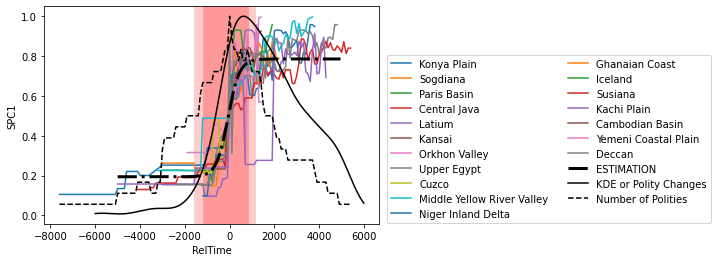

In [28]:
# Time Series Data fpr Reltime vs. SPC1
for N in list(set(RelTimeDF["NGA"])):
    DF = RelTimeDF[RelTimeDF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    
# Interpolation
x_show = np.arange(-1,1,0.01)    
y_hat = f(x_show, Parameters[0], Parameters[1], Parameters[2], Parameters[3])
plt.plot(x_show*T, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # scaled by T
plt.ylabel("SPC1")
plt.xlabel("RelTime")

# Denote the Regions of fast growth
plt.axvspan(Times[1], Times[2], facecolor='r', alpha=0.4)
plt.axvspan(Times[2], Times[3], facecolor='r', alpha=0.2)
plt.axvspan(Times[0], Times[1], facecolor='r', alpha=0.2)

# KDE of the polity changes
plt.plot(time_range, KDE_t / max(KDE_t), c="k", label="KDE or Polity Changes")

plt.plot(NumberPol["RelTime"], NumberPol["NumberPol"]/np.max(NumberPol["NumberPol"]), "--", c="k",
        label="Number of Polities")

plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)

plt.show()

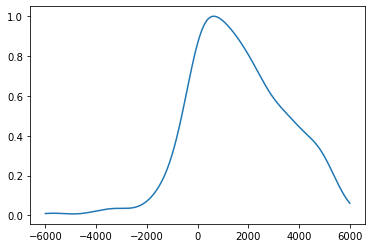

In [29]:
Changes_round = Relationships["Polity.End.Scaled"].round(-2)
KDE_round = gaussian_kde(Changes_round)
time_range = np.arange(-6000,6000,10)
kde_round = KDE_round(time_range)
plt.plot(time_range, kde_round / max(kde_round))
plt.show()

In [30]:
# take the rounded changes in polity
# and construct a frequency table
Changes_FrequencyTable = pd.DataFrame(columns = np.arange(T_min, T_max+100, 100))

for t in Changes_FrequencyTable.columns:
    Changes_FrequencyTable[int(t)] = sum(Changes_round==t)

print(Changes_FrequencyTable)


Empty DataFrame
Columns: [-7600, -7500, -7400, -7300, -7200, -7100, -7000, -6900, -6800, -6700, -6600, -6500, -6400, -6300, -6200, -6100, -6000, -5900, -5800, -5700, -5600, -5500, -5400, -5300, -5200, -5100, -5000, -4900, -4800, -4700, -4600, -4500, -4400, -4300, -4200, -4100, -4000, -3900, -3800, -3700, -3600, -3500, -3400, -3300, -3200, -3100, -3000, -2900, -2800, -2700, -2600, -2500, -2400, -2300, -2200, -2100, -2000, -1900, -1800, -1700, -1600, -1500, -1400, -1300, -1200, -1100, -1000, -900, -800, -700, -600, -500, -400, -300, -200, -100, 0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, ...]
Index: []

[0 rows x 131 columns]


In [31]:
Changes_FrequencyTable = pd.DataFrame( columns = ["RelTime", "NumberChanges", "NormedChanges"])

for t in np.arange(T_min, T_max+100, 100):
    Number_of_Polities = NumberPol["NumberPol"].loc[NumberPol["RelTime"]==t][0] # number of polities at time t
    Changes_FrequencyTable = pd.concat((Changes_FrequencyTable,
                                       pd.DataFrame(data={"RelTime": [t],
                                                         "NumberChanges": [sum(Changes_round==t)],
                                                         "NormedChanges": [sum(Changes_round==t) / Number_of_Polities]})))
    
print(Changes_FrequencyTable)

   RelTime NumberChanges  NormedChanges
0    -7600             0            0.0
0    -7500             0            0.0
0    -7400             0            0.0
0    -7300             0            0.0
0    -7200             0            0.0
..     ...           ...            ...
0     5000             4            4.0
0     5100             0            0.0
0     5200             3            3.0
0     5300             0            0.0
0     5400             2            2.0

[131 rows x 3 columns]


In [32]:
Changes_round

42      200.0
44      300.0
46      500.0
49      800.0
51      900.0
        ...  
830    4800.0
834    4900.0
858    1400.0
861    1400.0
862    1500.0
Name: Polity.End.Scaled, Length: 294, dtype: float64

In [33]:
Changes_FrequencyTable

,RelTime,NumberChanges,NormedChanges
0,-7600,0,0.0
0,-7500,0,0.0
0,-7400,0,0.0
0,-7300,0,0.0
0,-7200,0,0.0
...,...,...,...
0,5000,4,4.0
0,5100,0,0.0
0,5200,3,3.0
0,5300,0,0.0


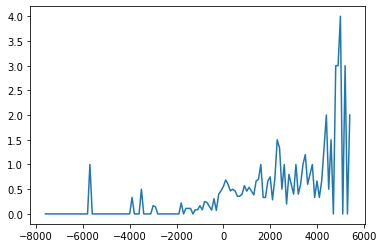

In [34]:
plt.plot(Changes_FrequencyTable["RelTime"],Changes_FrequencyTable["NormedChanges"], label ="Normed")


[]

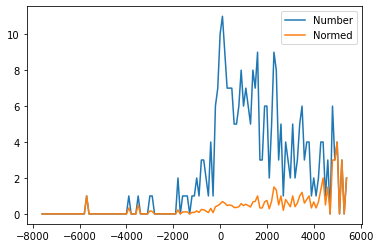

In [35]:
plt.plot(Changes_FrequencyTable["RelTime"],Changes_FrequencyTable["NumberChanges"], label="Number")
plt.plot(Changes_FrequencyTable["RelTime"],Changes_FrequencyTable["NormedChanges"], label ="Normed")
plt.legend()
plt.plot()

In [36]:
Changes_FrequencyTable

,RelTime,NumberChanges,NormedChanges
0,-7600,0,0.0
0,-7500,0,0.0
0,-7400,0,0.0
0,-7300,0,0.0
0,-7200,0,0.0
...,...,...,...
0,5000,4,4.0
0,5100,0,0.0
0,5200,3,3.0
0,5300,0,0.0


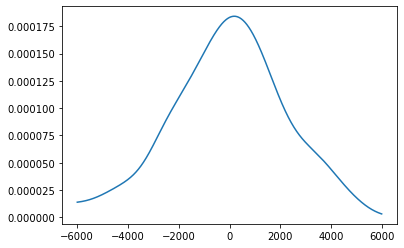

In [37]:
KDE_RelTime = gaussian_kde(RelTimeDF["RelTime"])
kde_reltime = gaussian_kde(RelTimeDF["RelTime"])
plt.plot(np.arange(-6000,6000,10), kde_reltime(np.arange(-6000,6000,10)))

In [38]:
def FT_to_Hist(df, Scale = 1):
    # Takes a frequency table
    # Scales the frequencies with Scale
    # takes the Gaussian floor function
    # and turns the frequency table into a list of events, e.g.
    # A with Frequency 2 and Scaling 2 is turned into [A, A, A, A]
    NP = df.to_numpy()
    Output = list()
    for i in range(df.shape[0]): # go through all lines
        freq = int(NP[i,1] * Scale)
        for j in range(freq): # append as often to the list as "Frequency * Scale"
            Output.append(NP[i,0])
    return(Output)

In [39]:
## Test
FT_to_Hist(pd.DataFrame(data={"Thing":["a", "b", "c"],
                             "Freq": [2, 0, 0.9]}),
          Scale = 2)

['a', 'a', 'a', 'a', 'c']

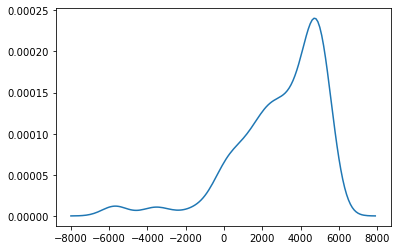

In [40]:
Normed_Changes_List = FT_to_Hist(Changes_FrequencyTable[["RelTime", "NormedChanges"]], 
                                 Scale = 10)
KDE_normed_changes = gaussian_kde(Normed_Changes_List)
yearrange = np.arange(-8000,8000,100)
kde_normed_changes = KDE_normed_changes(yearrange)
plt.plot(yearrange, kde_normed_changes)

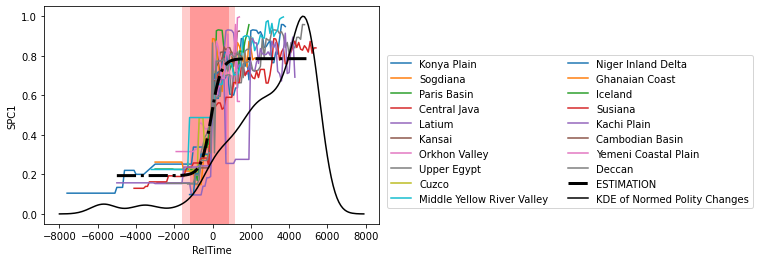

In [41]:
# Time Series Data fpr Reltime vs. SPC1
for N in list(set(RelTimeDF["NGA"])):
    DF = RelTimeDF[RelTimeDF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    
# Interpolation
x_show = np.arange(-1,1,0.01)    
y_hat = f(x_show, Parameters[0], Parameters[1], Parameters[2], Parameters[3])
plt.plot(x_show*T, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # scaled by T
plt.ylabel("SPC1")
plt.xlabel("RelTime")

# Denote the Regions of fast growth
plt.axvspan(Times[1], Times[2], facecolor='r', alpha=0.4)
plt.axvspan(Times[2], Times[3], facecolor='r', alpha=0.2)
plt.axvspan(Times[0], Times[1], facecolor='r', alpha=0.2)

# KDE of the polity changes
plt.plot(yearrange, kde_normed_changes / max(kde_normed_changes), 
         c="k", label="KDE of Normed Polity Changes")

#plt.plot(NumberPol["RelTime"], NumberPol["NumberPol"]/np.max(NumberPol["NumberPol"]), "--", c="k",
#        label="Number of Polities")

plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)

plt.show()

In [42]:
Changes_FrequencyTable.to_numpy()[:,0]

array([-7600, -7500, -7400, -7300, -7200, -7100, -7000, -6900, -6800,
       -6700, -6600, -6500, -6400, -6300, -6200, -6100, -6000, -5900,
       -5800, -5700, -5600, -5500, -5400, -5300, -5200, -5100, -5000,
       -4900, -4800, -4700, -4600, -4500, -4400, -4300, -4200, -4100,
       -4000, -3900, -3800, -3700, -3600, -3500, -3400, -3300, -3200,
       -3100, -3000, -2900, -2800, -2700, -2600, -2500, -2400, -2300,
       -2200, -2100, -2000, -1900, -1800, -1700, -1600, -1500, -1400,
       -1300, -1200, -1100, -1000, -900, -800, -700, -600, -500, -400,
       -300, -200, -100, 0, 100, 200, 300, 400, 500, 600, 700, 800, 900,
       1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000,
       2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100,
       3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200,
       4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300,
       5400], dtype=object)

In [43]:
Changes_FrequencyTable["NormedChanges"].loc[Changes_FrequencyTable["NormedChanges"]!=0]

0    1.000000
0    0.333333
0    0.500000
0    0.166667
0    0.142857
       ...   
0    3.000000
0    3.000000
0    4.000000
0    3.000000
0    2.000000
Name: NormedChanges, Length: 73, dtype: float64

In [44]:
for i in Changes_round:
    print(i,sum(Changes_round == i))

200.0 9
300.0 7
500.0 7
800.0 6
900.0 8
1100.0 7
1300.0 5
1500.0 7
1600.0 9
200.0 9
400.0 7
700.0 5
900.0 8
-1200.0 1
-900.0 1
-800.0 3
-800.0 3
-400.0 4
-400.0 4
-200.0 6
-200.0 6
0.0 10
100.0 11
100.0 11
100.0 11
300.0 7
0.0 10
100.0 11
800.0 6
1100.0 7
1300.0 5
1500.0 7
1600.0 9
1600.0 9
1900.0 6
2200.0 5
2100.0 2
-100.0 7
-100.0 7
100.0 11
-0.0 10
100.0 11
-3000.0 1
-1500.0 1
-700.0 3
0.0 10
400.0 7
4300.0 4
2000.0 6
2200.0 5
2300.0 9
2500.0 3
2800.0 4
3000.0 2
3100.0 5
3100.0 5
3200.0 2
3400.0 5
4000.0 2
4400.0 4
4300.0 4
-5700.0 1
-3900.0 1
-2900.0 1
-1600.0 1
-700.0 3
-200.0 6
100.0 11
300.0 7
800.0 6
900.0 8
1100.0 7
1200.0 6
1200.0 6
1500.0 7
-3500.0 1
-1000.0 2
0.0 10
0.0 10
300.0 7
600.0 5
800.0 6
1100.0 7
1300.0 5
1300.0 5
1700.0 3
1700.0 3
1900.0 6
1900.0 6
2300.0 9
2300.0 9
2300.0 9
2300.0 9
2300.0 9
2400.0 8
2400.0 8
2400.0 8
2400.0 8
2400.0 8
2600.0 5
2600.0 5
2900.0 3
3100.0 5
3300.0 3
3300.0 3
3300.0 3
3400.0 5
3500.0 6
3700.0 4
3800.0 4
3800.0 4
3900.0 1
-1100.0 1
-2

## Deal with the Continuity of Polities

In [45]:
 # this DF tells is, if a polity in an NGA is continuous or not
print(Relationships)
print(sorted(list(set(Relationships["NGA"])))) # only the long-lived ones remain

                      NGA    PolID               Longform.Name  Polity.Start  \
42        Cambodian Basin  KhFunaE                     Funan I         225.0   
44        Cambodian Basin  KhFunaL                    Funan II         540.0   
46        Cambodian Basin  KhChenl                      Chenla         550.0   
49        Cambodian Basin  KhAngkE                Early Angkor         802.0   
51        Cambodian Basin  KhAngkC            Classical Angkor        1100.0   
..                    ...      ...                         ...           ...   
830           Upper Egypt  TrOttm3           Ottoman Empire II        1517.0   
834           Upper Egypt  TrOttm4          Ottoman Empire III        1683.0   
858  Yemeni Coastal Plain  YeQasmi     Yemen - Qasimid Dynasty        1637.0   
861  Yemeni Coastal Plain  TrOttm4          Ottoman Empire III        1683.0   
862  Yemeni Coastal Plain  YeOttoL  Ottoman Empire Late Period        1873.0   

     Polity.End Dupl            Section

In [46]:
print(Relationships[["NGA", "Polity.End.Scaled"]].loc[Relationships["Value.From"]=="discontinuity"].iloc[50:70])

             NGA  Polity.End.Scaled
580     Sogdiana              -50.0
587     Sogdiana              529.0
593     Sogdiana             1061.0
606     Sogdiana             1712.0
699      Susiana             1617.0
708      Susiana             2300.0
710      Susiana             2500.0
713      Susiana             2600.0
726      Susiana             3740.0
744      Susiana             4762.0
745      Susiana             4762.0
746      Susiana             4857.0
747      Susiana             4857.0
754      Susiana             5039.0
756      Susiana             5039.0
757      Susiana             5201.0
764      Susiana             5422.0
765      Susiana             5625.0
784  Upper Egypt             2353.0
788  Upper Egypt             2575.0


In [47]:
Breakpoints = Relationships[["NGA", "Polity.End.Scaled"]].loc[Relationships["Value.From"]=="discontinuity"]
Breakpoints.columns = ["NGA", "RelTime"]
Breakpoints.head()

,NGA,RelTime
67,Central Java,718.0
138,Cuzco,-751.0
142,Cuzco,-401.0
145,Cuzco,-150.0
149,Cuzco,132.0


In [48]:
# Get the snippet that includes RelTime=0 and does not have any discontinuity
def Cutout(nga, df = RelTimeDF):
    
    
    Output = df.loc[df["NGA"]==nga]
    
    # if the nga has a discontinuous breakpoint, we need to cut out the central part of Output around 0
    if nga in set(Breakpoints["NGA"]):
        
        # get this nga's breakpoints
        BPs = Breakpoints.loc[Breakpoints["NGA"] == nga]
        
        
        # isolate the first breakpoint above zero
        # NOT exactly zero, because a breakpoint at zero means that up to RelTime 0, the polity has changed
        BP_positive = BPs.loc[BPs["RelTime"] > 0]
        
        if BP_positive.shape[0]>0: # is there any Breakpoint after 0?
            BP_end = min(BP_positive["RelTime"])
        else:
            BP_end = np.infty # else: latest possible year
        
        # Now need the beginning of the cutout-area, i.e. the last breakpoint before BP_end
        BP_rest = BPs.loc[BPs["RelTime"] < BP_end]
        
        
        if BP_rest.shape[0] > 0: # is there even a breakpoint before this?
            BP_start = max(BP_rest["RelTime"])
        else:
            BP_start = -np.inf # else: set the earliest possible time as beginning for the cutout
    
        print("BPs",BPs)
        print(BP_start,BP_end)
        
        Output = Output.loc[Output["RelTime"] > BP_start-1 ]
        Output = Output.loc[Output["RelTime"] < BP_end +1 ]
        
    return(Output)

In [49]:
## Test
Cutout_DF = pd.DataFrame(columns = RelTimeDF.columns)
Cutout_CCDF = pd.DataFrame(columns = RelTimeCCDF.columns)

for n in list(set(RelTimeDF["NGA"])):
    print(Cutout(n))
    Cutout_DF = pd.concat((Cutout_DF, Cutout(n)))
    Cutout_CCDF = pd.concat((Cutout_CCDF, Cutout(n, RelTimeCCDF)))

BPs              NGA  RelTime
294  Konya Plain      0.0
317  Konya Plain   2284.0
318  Konya Plain   2284.0
319  Konya Plain   2284.0
320  Konya Plain   2284.0
321  Konya Plain   2284.0
345  Konya Plain   3307.0
347  Konya Plain   3339.0
349  Konya Plain   3339.0
350  Konya Plain   3402.0
0.0 2284.0
             NGA  RelTime      SPC1
326  Konya Plain        0  0.584207
327  Konya Plain      100  0.584207
328  Konya Plain      200  0.584207
329  Konya Plain      300  0.584207
330  Konya Plain      400  0.666110
331  Konya Plain      500  0.688037
332  Konya Plain      600  0.678982
333  Konya Plain      700  0.693366
334  Konya Plain      800  0.694619
335  Konya Plain      900  0.605398
336  Konya Plain     1000  0.605398
337  Konya Plain     1100  0.600754
338  Konya Plain     1200  0.637261
339  Konya Plain     1300  0.637261
340  Konya Plain     1400  0.763214
341  Konya Plain     1500  0.887021
342  Konya Plain     1600  0.884932
343  Konya Plain     1700  0.746792
344  Konya Plai

BPs        NGA  RelTime
138  Cuzco   -751.0
142  Cuzco   -401.0
145  Cuzco   -150.0
149  Cuzco    132.0
152  Cuzco    132.0
-150.0 132.0
BPs        NGA  RelTime
138  Cuzco   -751.0
142  Cuzco   -401.0
145  Cuzco   -150.0
149  Cuzco    132.0
152  Cuzco    132.0
-150.0 132.0
BPs                             NGA  RelTime
422  Middle Yellow River Valley   1029.0
426  Middle Yellow River Valley   1396.0
428  Middle Yellow River Valley   1575.0
432  Middle Yellow River Valley   1809.0
447  Middle Yellow River Valley   2927.0
452  Middle Yellow River Valley   3444.0
-inf 1029.0
                            NGA  RelTime      SPC1
525  Middle Yellow River Valley    -3200  0.224902
526  Middle Yellow River Valley    -3100  0.224902
527  Middle Yellow River Valley    -3000  0.224902
528  Middle Yellow River Valley    -2900  0.224902
529  Middle Yellow River Valley    -2800  0.224902
530  Middle Yellow River Valley    -2700  0.224902
531  Middle Yellow River Valley    -2600  0.224902
532  Middle Yel

                 NGA  RelTime      SPC1
186  Cambodian Basin        0  0.673646
187  Cambodian Basin      100  0.673646
188  Cambodian Basin      200  0.673646
189  Cambodian Basin      300  0.664762
190  Cambodian Basin      400  0.753940
191  Cambodian Basin      500  0.783000
192  Cambodian Basin      600  0.844609
193  Cambodian Basin      700  0.828656
194  Cambodian Basin      800  0.840909
195  Cambodian Basin      900  0.840909
196  Cambodian Basin     1000  0.812885
197  Cambodian Basin     1100  0.812885
198  Cambodian Basin     1200  0.810691
199  Cambodian Basin     1300  0.806051
200  Cambodian Basin     1400  0.806733
201  Cambodian Basin     1500  0.797299
BPs                       NGA  RelTime
862  Yemeni Coastal Plain   1520.0
-inf 1520.0
                      NGA  RelTime      SPC1
595  Yemeni Coastal Plain        0  0.729010
596  Yemeni Coastal Plain      100  0.729010
597  Yemeni Coastal Plain      200  0.874002
598  Yemeni Coastal Plain      300  0.841906
599  Yeme

In [50]:
Cutout_DF, Cutout_CCDF


(             NGA RelTime      SPC1
 326  Konya Plain       0  0.584207
 327  Konya Plain     100  0.584207
 328  Konya Plain     200  0.584207
 329  Konya Plain     300  0.584207
 330  Konya Plain     400  0.666110
 ..           ...     ...       ...
 164       Deccan     800  0.722243
 165       Deccan     900  0.804721
 166       Deccan    1000  0.811569
 167       Deccan    1100  0.793230
 168       Deccan    1200  0.794156
 
 [365 rows x 3 columns],
              NGA RelTime      SPC1    PolPop   PolTerr    CapPop    levels  \
 326  Konya Plain       0  0.584207  4.895143  4.309285  3.958917  2.946331   
 327  Konya Plain     100  0.584207  4.895143  4.309285  3.958917  2.946331   
 328  Konya Plain     200  0.584207  4.895143  4.309285  3.958917  2.946331   
 329  Konya Plain     300  0.584207  4.895143  4.309285  3.958917  2.946331   
 330  Konya Plain     400  0.666110  6.016334  4.802042  4.047459  4.280181   
 ..           ...     ...       ...       ...       ...       ...  

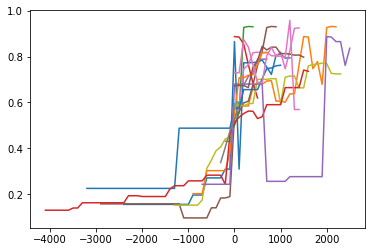

In [51]:
Cutout_DF
for n in list(set(Cutout_DF["NGA"])):
    smalldf = Cutout_DF.loc[Cutout_DF["NGA"]==n]
    #print(smalldf)
    plt.plot(smalldf["RelTime"], smalldf["SPC1"])
plt.show()

# Redo the RelTime Analysis with this Data?

## Fitting

In [52]:
X, y = Cutout_DF["RelTime"].to_numpy(), Cutout_DF["SPC1"].to_numpy()
T = 5000
X = np.array(list(X)) # for some reason, this transformation is necessary
X = X/T # normalisation of the data

def f(x, a, b, c, d):
    # the logistic function in its most general shape
    return a / (1. + np.exp(-c * (x - d))) + b

(a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, p0 = Parameters)

P0 = np.array((a_, b_, c_, d_))
print(P0)

[ 5.05526191e-01  2.04512959e-01  4.20835754e+01 -2.17749685e-02]


In [53]:
# comparison with full data:
Parameters

array([ 5.91641013e-01,  1.93784865e-01,  1.93749266e+01, -1.54321375e-02])

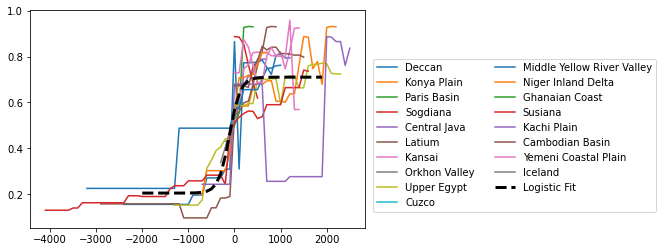

In [54]:
Cutout_DF
for n in list(set(Cutout_DF["NGA"])):
    smalldf = Cutout_DF.loc[Cutout_DF["NGA"]==n]
    #print(smalldf)
    plt.plot(smalldf["RelTime"], smalldf["SPC1"], label=n)

TimeRange = np.arange(-2000,2000,100)
New_Fit = f(TimeRange/T, a_, b_, c_, d_)
plt.plot(TimeRange, New_Fit, "--",label="Logistic Fit", c="k", linewidth = 3)
plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)
plt.show()

## Bootstrapping

In [55]:

nBT = 1000 # how many Bootstraps
negCcount = 0

Params = pd.DataFrame(columns = ["a", "b", "c", "d"]) # df of the parameters
NGA_list = list(set(Cutout_DF["NGA"]))


for i in range(nBT):
    NGA_selection = random.choices(NGA_list,k=len(NGA_list))
    Data_Bootstrap = pd.DataFrame(columns = Cutout_DF.columns)

    for n in NGA_selection:
        Data_Bootstrap = pd.concat([Data_Bootstrap, Cutout_DF[Cutout_DF["NGA"]==n]])
    
    
    X, y = Data_Bootstrap["RelTime"].to_numpy(), Data_Bootstrap["SPC1"].to_numpy()

    X = np.array(list(X)) # for some reason, this transformation is necessary
    X = X/T # normalisation of the data
    (a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, P0) # p0: Initial guess = Full Estimation
                                                     # Otherwise: direction can reverse with c<0

    Params = pd.concat([Params,
                       pd.DataFrame(data={"a":[a_], "b":[b_], "c":[c_], "d":[d_]})])
    if c_ < 0:
        print(NGA_selection)
        negCcount +=1
        for N in NGA_selection:
            DF = Data_RT[Data_RT["NGA"] == N]
            plt.plot(DF["RelTime"]/T,    # ALSO normalised
            DF["SPC1"], label=N)
            plt.plot(x_show, y_hat, "-.",label="ESTIMATION", c = "k", linewidth=3) # FOR FULL DATA
            plt.plot(x_show, f(x_show, a_, b_, c_, d_), "-.",c="r", linewidth = 3)

        plt.show()
        
    print(a_, b_, c_, d_)
    print("-----------------")
print(Params.round(2))

0.5665885096752517 0.19828070677963439 35.10190073955968 -0.021735706348581123
-----------------
0.34293230984015693 0.3081238708570104 856.8891278807718 -0.01868171761066895
-----------------
0.5726896621098172 0.1740245158128846 25.293636638296178 -0.026446745368184643
-----------------
0.4288947568613017 0.23607284565125283 236.45867871713062 -0.016463999828391664
-----------------
0.5186283207307629 0.17312032375095415 110.95851627311325 -0.013702688028782443
-----------------
0.553883479477843 0.16750300784532704 40.32955668776994 -0.01750213788390052
-----------------
0.4593127613300871 0.1912444590722769 100.22298664122711 -0.0186083738571388
-----------------
0.575637219859105 0.19552162661774808 22.349141936262278 -0.012439284329754118
-----------------
0.5275308887580498 0.18522803661493775 41.74062258969825 -0.02504652992465854
-----------------
0.5100832129631147 0.1959998687980728 78.16031407024755 -0.021978780130495396
-----------------
0.5409525322149855 0.17187286595359

0.5674870786239014 0.19225775414700827 15.378022215508851 -0.029663042506196696
-----------------
0.4816235427986422 0.23043962861827375 44.54746951584067 -0.021544670603019494
-----------------
0.5426925398943191 0.19929385355482285 34.912056124954105 -0.02447893890545162
-----------------
0.46853260371786176 0.18786672462417262 837.5738266488357 -0.018995068485030676
-----------------
0.4260487478136479 0.24874448555579984 34.25931034313475 -0.03290815391675738
-----------------
0.47268749842343377 0.20119744767988945 61.39760210426886 -0.019337176754025895
-----------------
0.5830654307024575 0.20724827589123618 17.2970832122233 -0.027140757510071518
-----------------
0.4825303540457699 0.2191954075064989 30.678019347139955 -0.029256293023968327
-----------------
0.6804929332266386 0.14583118377235876 29.77528998189671 -0.007543640693917896
-----------------
0.4771713369797476 0.17868361923635595 124.60183648516775 -0.015113904330119474
-----------------
0.5518477473023913 0.2158166

C:\Users\Tobias\AppData\Local\Temp/ipykernel_20100/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


0.5222100193485989 0.19709031138357466 28.450475626649485 -0.03349480139159831
-----------------
0.5331578408915235 0.1987462220721573 37.699973032431885 -0.019302439082673692
-----------------
0.5124755276696602 0.1916154628359017 28.093597378954804 -0.02922325819599856
-----------------
0.469008328571141 0.21461953269789874 45.088102792828884 -0.022427299795966665
-----------------
0.4523374757258524 0.22548064590827427 50.12770015645452 -0.020797371072291758
-----------------
0.5008091391705216 0.22658612648155707 45.52201836176984 -0.016954740151703788
-----------------
0.4535911122180963 0.19803750041800094 68.55759753423348 -0.023966421906368704
-----------------
0.33817219825055517 0.26239323212554344 1103.845272552476 -0.01908047391869384
-----------------
0.4914494282449551 0.17135955778779863 41.27709642261974 -0.02121959085735786
-----------------
0.6057971416827265 0.1646371769919079 29.87854005336501 -0.01657409210288835
-----------------
0.44540277144060336 0.246078851676

0.4427941163866731 0.25812341528519017 67.54174949574909 -0.01594587946128322
-----------------
0.5851813711917949 0.1598717174762577 37.02208937524924 -0.01657554667876619
-----------------
0.5568571379966554 0.18402073159047738 26.595411615225345 -0.02615275174341136
-----------------
0.49024003349094497 0.18813304412336598 12.659818541896433 -0.06672466724203575
-----------------
0.49813928363034327 0.19680436699358048 53.2949186220517 -0.018633089471411936
-----------------
0.5106727587800619 0.2218321645229782 59.296984400975106 -0.01425562180942519
-----------------
0.4811944436287724 0.1982986897817706 79.58748486855858 -0.02120784241703799
-----------------
0.5843948489741748 0.18202935764827208 34.546167273707304 -0.016233407191920186
-----------------
0.49216745583948623 0.18864211439431647 69.13392809793066 -0.02149750092886779
-----------------
0.5283198707122927 0.18610909050485328 46.854035719402724 -0.022646972748386163
-----------------
0.5705522643263166 0.205317976844

0.4643339693138682 0.22835404863816214 39.516106106741 -0.023828012404782908
-----------------
0.4539496654145876 0.18660204496517813 62.12548592778211 -0.023887886577302696
-----------------
0.5525911765502062 0.18369071877671345 34.29950068888319 -0.02698832447763948
-----------------
0.45102153438541975 0.26138809894039455 33.087788053253654 -0.027101577480535877
-----------------
0.5711210847271542 0.16543373193474917 42.744594800003696 -0.019228920260009816
-----------------
0.5495347523224007 0.17147825774772743 91.41363053873783 -0.016683782015674015
-----------------
0.532934297943761 0.22814476991428392 31.27702422946792 -0.02363359881974654
-----------------
0.5824133029053965 0.1963162100253248 13.566954396585418 -0.0429966619251437
-----------------
0.47146268083746257 0.21246950584632246 58.796013298165875 -0.02239773171335555
-----------------
0.5296916677246515 0.19387610689029558 27.508133883149764 -0.028125955593519113
-----------------
0.5812892558168653 0.18102356064

0.5778497777368323 0.1993072721594381 22.952487979205156 -0.01927562420173383
-----------------
0.5688251768688475 0.164656894675478 49.03679265787286 -0.017588756633764448
-----------------
0.5373113341419009 0.18345876499833771 36.94592512534635 -0.02417310064831682
-----------------
0.5722115963004035 0.19918705466094228 30.905690832541374 -0.021718380702325023
-----------------
0.5189440131574501 0.19265351905621927 42.55433776151493 -0.016023823650295855
-----------------
0.5760704492401836 0.17083363796218665 28.588989972156938 -0.024700860209835043
-----------------
0.5628151328678987 0.17154015708112091 32.14983098195508 -0.022769205872362277
-----------------
0.483475386815828 0.1951636714386957 48.2164522584718 -0.02352049256005745
-----------------
0.5940653767963288 0.2289869057567577 20.407014062606976 -0.012332581398716057
-----------------
0.4882873798427215 0.21421031593079723 40.15985212275086 -0.02218815459592043
-----------------
0.5308137025913793 0.1865795262707562

0.4268999394559822 0.2134957394864342 134.4890237876699 -0.015627511748867937
-----------------
0.4228154520603278 0.24550951370217525 38.863095736974245 -0.029890024327556806
-----------------
0.4406567084476695 0.20499414832689447 923.6939094040923 -0.01882610852471242
-----------------
0.591010635075045 0.19330945445805936 11.656348652402311 -0.03746166941737925
-----------------
0.4483456767047837 0.257494050403683 52.70174099817391 -0.019688040927421723
-----------------
0.5698468818411933 0.17436669940046887 33.03929668399271 -0.017156481730861962
-----------------
0.5311606633291885 0.17894593479378534 36.854810573052674 -0.016594139618263042
-----------------
0.4608349477754236 0.20717403007356092 62.099275563697574 -0.02045793137118972
-----------------
0.47314425920090025 0.2276662866912634 118.38452072730239 -0.015078975047026821
-----------------
0.5664016559849294 0.19069622527107527 25.0099962134757 -0.02653032442912147
-----------------
0.5838329277549238 0.2046184151382

0.5564925075352454 0.22916829548058776 22.088842129790986 -0.02165565540828687
-----------------
0.5686654425240649 0.19053835965743546 35.07087020249829 -0.020317632675937305
-----------------
0.34623843708805235 0.24601490754745864 357.4962823944765 -0.018427432407640408
-----------------
0.5719799168715193 0.15306454748816517 50.93163293598683 -0.016081872459840926
-----------------
0.571159123806681 0.1780735398437799 44.50448128056397 -0.023559839875315902
-----------------
0.49827805732094477 0.20247284968156398 42.24046400388322 -0.022493502333123697
-----------------
0.5234419310334184 0.16791802878789444 36.23557942826536 -0.02281975182559138
-----------------
0.5595699646132497 0.1837232665278823 27.24165504969264 -0.01838758051241061
-----------------
0.535169821449685 0.16843058362568814 35.74284997627477 -0.028364481064966574
-----------------
0.5267277476542787 0.20543126102425724 21.37956167112308 -0.023962868632029267
-----------------
0.5379158099413194 0.2421946686771

0.5375840972299564 0.2240373983802515 16.529247821461 -0.042356705145543475
-----------------
0.60303855736977 0.15331857869391846 24.623360341662536 -0.041723557448691696
-----------------
0.529321140855807 0.17426596925231902 69.52287411117987 -0.01859756452849199
-----------------
0.5024758153174682 0.21170775297378208 31.140282973495886 -0.027021878595275696
-----------------
0.4878609516566513 0.2251368491874478 36.45892217987958 -0.025932797833007802
-----------------
0.6199850677395443 0.15753433905791 35.066019637456705 -0.016681080871346614
-----------------
0.43083975727632123 0.253490186478894 50.49740363167607 -0.021553500767003925
-----------------
0.5686948357091876 0.1966328942090311 23.241035590637097 -0.016996689460556654
-----------------
0.4869644016864579 0.2187876138854732 36.35631540263141 -0.024163519698457918
-----------------
0.5540279823281221 0.19052171888434177 26.156120125149048 -0.026808344457598162
-----------------
0.4797622327749884 0.22846417019653997 

0.5443199928441692 0.18216401267243754 49.1503663388078 -0.015047916219903645
-----------------
0.5873605529413344 0.22414174798707517 24.448952849455264 -0.013816319374124806
-----------------
0.46168542921830813 0.21036686842987645 141.2417987660065 -0.01761626994987202
-----------------
0.5595967948680599 0.21861860720998105 30.39808521993191 -0.013703948280231727
-----------------
0.5713987704532483 0.21672482135408166 16.001657261170294 -0.04754051429066506
-----------------
0.4278879314786871 0.23146474768909753 102.1413512645807 -0.01849071447337922
-----------------
0.5594465623183184 0.17912560676961442 28.77139699509986 -0.029032404009741986
-----------------
0.5211726113743508 0.1899195314504633 24.78201186438755 -0.03066495902948106
-----------------
0.48243898213293857 0.18860598776436666 43.00812898653866 -0.026357881115513952
-----------------
0.5202535419281781 0.19521349796438614 129.8852999417502 -0.013171226903712778
-----------------
0.5668651656109763 0.16736708258

0.49553060938837556 0.22171780869535418 39.615385126022254 -0.01908610141224294
-----------------
0.5130503741582204 0.2506874628639621 32.37905476685177 -0.016812012754102733
-----------------
0.47314866113142523 0.20177933588143648 48.515604741016645 -0.02177066764584875
-----------------
0.4877905261207637 0.190526350297617 131.71278183340854 -0.013813580512408049
-----------------
0.5382308723534002 0.2187981616224101 22.92162650143116 -0.027073184706020458
-----------------
0.5309649612892675 0.17799213040446515 43.718826616181126 -0.017826431620870845
-----------------
0.537448346038247 0.2014753012674772 14.927877925112925 -0.0445712069113625
-----------------
0.5113161083437103 0.21534358872353243 31.36041863558103 -0.023615502308937494
-----------------
0.4679805036479012 0.2109068469744091 52.52681236780857 -0.020596826740287098
-----------------
0.5814564199268291 0.19887063868090274 12.30233795671205 -0.04715315874607519
-----------------
0.4216281940783662 0.24672427355765

0.4870621888954365 0.2272766728702958 44.82208761323598 -0.016631601206280294
-----------------
0.5279429661282258 0.1932805302670484 30.081536188303872 -0.02830769027901787
-----------------
0.5055640474057015 0.1676751937413274 41.370499229127184 -0.02782399665602902
-----------------
0.5663958102687034 0.21659641872004293 20.337003722089147 -0.027723628876930157
-----------------
0.5046543715788382 0.19909701505190747 35.5994513603447 -0.019891065416917625
-----------------
0.45369598285050794 0.21598332839981016 23.093368813118754 -0.03703545996881298
-----------------
0.604009730876063 0.15109519680453373 41.20527628722413 -0.01817205522203289
-----------------
0.5666644817865494 0.19491101367464356 37.82293786951316 -0.01774624421674451
-----------------
0.4729205667788247 0.22585878041758564 98.05689429918509 -0.016444445987807442
-----------------
0.6267568629221115 0.16291838301671235 31.91542734692738 -0.018233574532049046
-----------------
0.5123742931887542 0.19257997654922

In [56]:
print(negCcount)

0


In [57]:
Params

,a,b,c,d
0,0.566589,0.198281,35.101901,-0.021736
0,0.342932,0.308124,856.889128,-0.018682
0,0.572690,0.174025,25.293637,-0.026447
0,0.428895,0.236073,236.458679,-0.016464
0,0.518628,0.173120,110.958516,-0.013703
...,...,...,...,...
0,0.626766,0.171520,37.242187,-0.021453
0,0.451367,0.236738,41.612234,-0.024354
0,0.561038,0.217706,31.124169,-0.017684
0,0.547850,0.194228,29.359057,-0.027215


50% centred quantiles 0.47369044617869105 0.5611642712723327
90% centred quantiles 0.4248382212681995 0.5984119971547048


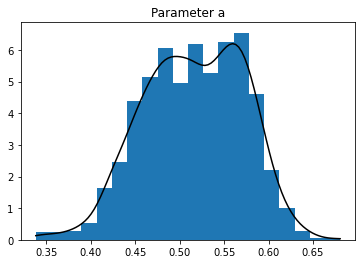

50% centred quantiles 0.18305374166373028 0.2184834915541383
90% centred quantiles 0.16542897117094632 0.25389757725967116


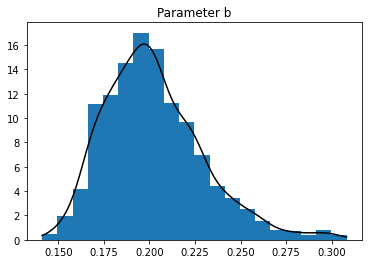

50% centred quantiles 28.95048668766916 58.021349909046336
90% centred quantiles 17.325612356927948 150.9251942758337


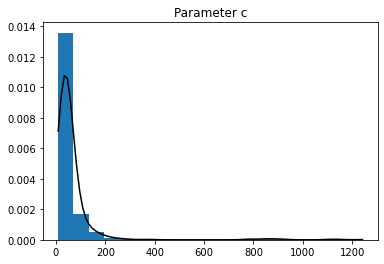

50% centred quantiles -0.02505427417696231 -0.016975303448050927
90% centred quantiles -0.03730392362674139 -0.013146028283078707


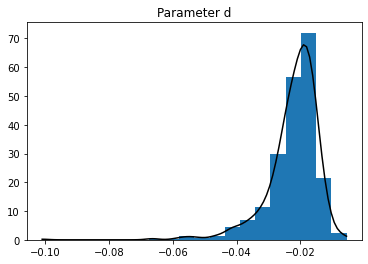

In [58]:
for P in Params.columns:
    
    
    Ps = Params[P]
    P_range = np.linspace(min(Ps), max(Ps),100)
    KDE = gaussian_kde(Ps)(P_range)
    
    print("50% centred quantiles", np.quantile(Ps, 0.25), 
          np.quantile(Ps, 0.75))
    print("90% centred quantiles", np.quantile(Ps, 0.05), 
          np.quantile(Ps, 0.95))
    plt.hist(Ps,bins=20, density= True)
    plt.plot(P_range, KDE, c="k")
    plt.title("Parameter "+str(P))
    plt.show()

### In more detail for c

In [59]:
np.quantile(Params["c"], 0.25), np.quantile(Params["c"], 0.75)

(28.95048668766916, 58.021349909046336)

[1.00000000e+00 1.25892541e+00 1.58489319e+00 1.99526231e+00
 2.51188643e+00 3.16227766e+00 3.98107171e+00 5.01187234e+00
 6.30957344e+00 7.94328235e+00 1.00000000e+01 1.25892541e+01
 1.58489319e+01 1.99526231e+01 2.51188643e+01 3.16227766e+01
 3.98107171e+01 5.01187234e+01 6.30957344e+01 7.94328235e+01
 1.00000000e+02 1.25892541e+02 1.58489319e+02 1.99526231e+02
 2.51188643e+02 3.16227766e+02 3.98107171e+02 5.01187234e+02
 6.30957344e+02 7.94328235e+02 1.00000000e+03 1.25892541e+03
 1.58489319e+03 1.99526231e+03 2.51188643e+03 3.16227766e+03
 3.98107171e+03 5.01187234e+03 6.30957344e+03 7.94328235e+03
 1.00000000e+04 1.25892541e+04 1.58489319e+04 1.99526231e+04
 2.51188643e+04 3.16227766e+04 3.98107171e+04 5.01187234e+04
 6.30957344e+04 7.94328235e+04]


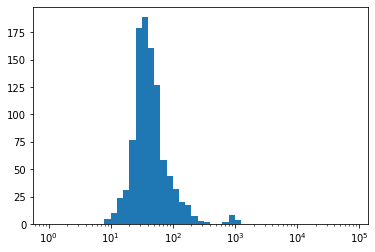

In [60]:
bins = 10**(np.arange(0,5,0.1))
print(bins)
plt.xscale('log')
plt.hist(Params["c"],bins=bins) 


plt.show()

### Analysis of the Curve

When does f(x) = y_est actually change? 
f(-infinity) = b and f(infinity) = a + b. We can now calculate the standard deviations of b and a+b via the bootstrap estimations and check when y_est exceeds b + sd(b) and reaches a+b - sd(a+b).

In [61]:
print(np.mean(Params["b"]), np.std(Params["b"]))
print(np.mean(Params["b"]+Params["a"]), np.std(Params["b"]+Params["a"]))

Thresh1 = np.mean(Params["b"]) + np.std(Params["b"])
Thresh2 = np.mean(Params["b"]+Params["a"]) - np.std(Params["b"]+Params["a"])
print(Thresh1, Thresh2)

def f1(x):
    # first threshold
    return(f(x, P0[0], P0[1], P0[2], P0[3])-Thresh1)

T1 = opt.root(f1, -0.5)

def f2(x):
    # second threshold
    return(f(x, P0[0], P0[1], P0[2], P0[3])-Thresh2)

T2 = opt.root(f2, 0.5)

0.20240265493230272 0.027290837482977195
0.7183685620248541 0.04248910040688078
0.22969349241527992 0.6758794616179733


C:\Users\Tobias\AppData\Local\Temp/ipykernel_20100/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


In [62]:
Timeframe = (T2["x"] -T1["x"])[0]
t_2, t_1 = T2["x"], T1["x"]
# scale this back to original time
print("Most of the cultural evolution takes place in a time interval of ", np.round(T*Timeframe), "years.")

Most of the cultural evolution takes place in a time interval of  1368.0 years.


## Bootstrapping the Time Interval

Now we can repeat this task, but 

-> Calculate the time thresholds T1/T2 for every single Bootstrapped Data and therefore calculate a time interval with standard deviation

In [63]:
def fBT1(x):
    # first threshold for the Bootstrapping
    return(f(x, a_, b_, c_, d_)-Thresh1)

def fBT2(x):
    # second threshold for the Bootstrapping
    return(f(x, a_, b_, c_, d_)-Thresh2)


In [64]:
random.seed(1234)
nBT = 1000 # how many Bootstraps
Successes = 0

Params2 = pd.DataFrame(columns = ["a", "b", "c", "d"]) # df of the parameters

for i in range(nBT):
    
    # Select the random NGAs
    NGA_selection = random.choices(NGA_list,k=len(NGA_list))
    Data_Bootstrap = pd.DataFrame(columns = Cutout_DF.columns)

    for n in NGA_selection: # combine them to a data frame
        Data_Bootstrap = pd.concat([Data_Bootstrap, Cutout_DF[Cutout_DF["NGA"]==n]])
    
    
    X, y = Data_Bootstrap["RelTime"].to_numpy(), Data_Bootstrap["SPC1"].to_numpy()

    X = np.array(list(X)) # for some reason, this transformation is necessary
    X = X/T # normalisation of the data
    (a_, b_, c_, d_), _ = opt.curve_fit(f, X, y, P0) # p0: Initial guess = Full Estimation
                                                     # Otherwise: direction can reverse with c<0
    
    # Time Intervals
    T1 = opt.root(fBT1, t_1)
    T2 = opt.root(fBT2, t_2)
    
    # only add results, if opt.root is successful:
    if T1["success"] and T2["success"]:
        Successes += 1
        Params2 = pd.concat([Params2,
                       pd.DataFrame(data={"a":[a_], "b":[b_], "c":[c_], "d":[d_], "T1":T1["x"], "T2":T2["x"]})])    
        print(a_, b_, c_, d_, T1, T2)
        print("-----------------")


0.4915116818997959 0.21909330497162985 53.72607975535702 -0.01988016742379103     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 22
     qtf: array([-3.62079811e-12])
       r: array([-0.55722371])
  status: 1
 success: True
       x: array([-0.090885])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-3.73945319e-12])
       r: array([-1.73385543])
  status: 1
 success: True
       x: array([0.02808053])
-----------------
0.5341394930287312 0.21994857874709017 16.774799648793998 -0.03306026293538246     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.42028619e-14])
       r: array([-0.16048663])
  status: 1
 success: True
       x: array([-0.27064873])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.04010134e-11])
       r: array([-1.1198412])
  status: 1

C:\Users\Tobias\AppData\Local\Temp/ipykernel_20100/1173144731.py:8: RuntimeWarning: overflow encountered in exp
  return a / (1. + np.exp(-c * (x - d))) + b


0.5687651322621415 0.19392983799142904 20.54551546277931 -0.016444945526165773     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([1.31838984e-14])
       r: array([-0.68857995])
  status: 1
 success: True
       x: array([-0.14793797])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.20796706e-11])
       r: array([-1.51141335])
  status: 1
 success: True
       x: array([0.06698223])
-----------------
0.5236843312533448 0.19117461710853872 44.743798232635434 -0.012676130191740706     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([1.84297022e-13])
       r: array([-1.59671263])
  status: 1
 success: True
       x: array([-0.06929496])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([9.15134635e-12])
       r: array([-1.61427307])
  status

0.6214987447900505 0.15960651784637642 32.53910991424799 -0.021275875510102585     fjac: array([[-1.]])
     fun: array([-1.21569421e-14])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([-1.18700594e-09])
       r: array([-2.02336537])
  status: 1
 success: True
       x: array([-0.08466866])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-7.15583148e-12])
       r: array([-2.844246])
  status: 1
 success: True
       x: array([0.0276046])
-----------------
0.5157845115888553 0.18991260224003764 29.727829131250456 -0.025726499286672637     fjac: array([[-1.]])
     fun: array([6.9388939e-16])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([1.70474468e-10])
       r: array([-1.09138468])
  status: 1
 success: True
       x: array([-0.1092186])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([9.3880459e-13])
       r: array([-

0.520095675952227 0.20725792200708826 34.88097802015875 -0.024954898913743903     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([4.98945329e-12])
       r: array([-0.74881691])
  status: 1
 success: True
       x: array([-0.11380762])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.15463195e-13])
       r: array([-1.61776976])
  status: 1
 success: True
       x: array([0.03836661])
-----------------
0.5173438133271591 0.20162139996750775 35.52082555263931 -0.01988390809446103     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([3.46667139e-14])
       r: array([-0.94303689])
  status: 1
 success: True
       x: array([-0.10034775])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([8.32667268e-15])
       r: array([

0.5905308780890957 0.15228263833218977 47.837180520755496 -0.014667036256063122     fjac: array([[-1.]])
     fun: array([-1.66533454e-16])
 message: 'The solution converged.'
    nfev: 22
     qtf: array([-8.18795587e-11])
       r: array([-3.21768105])
  status: 1
 success: True
       x: array([-0.05420496])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-4.61852778e-14])
       r: array([-2.83901107])
  status: 1
 success: True
       x: array([0.02833328])
-----------------
0.6164714889628237 0.15584006648038648 29.425705688805778 -0.01679446396369034     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([-1.32125699e-11])
       r: array([-1.91283944])
  status: 1
 success: True
       x: array([-0.08456933])     fjac: array([[-1.]])
     fun: array([6.66133815e-16])
 message: 'The solution converged.'
    nfev: 5
     qtf: array([-4.29618896e-10])
       r: 

0.4716403592301381 0.21768695582432665 42.653109066393355 -0.019687753850710327     fjac: array([[-1.]])
     fun: array([9.15933995e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([1.28514199e-10])
       r: array([-0.49907565])
  status: 1
 success: True
       x: array([-0.1051441])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([2.89286373e-11])
       r: array([-0.55723948])
  status: 1
 success: True
       x: array([0.06303705])
-----------------
0.5115025409116186 0.19113031537621328 39.22933326680884 -0.026063795269739256     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([6.0056432e-11])
       r: array([-1.39875725])
  status: 1
 success: True
       x: array([-0.08996163])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([5.78426196e-14])
       r: array(

       x: array([0.06367248])
-----------------
0.4760861939088206 0.22086688068861005 79.0563253899692 -0.018301983950486555     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 39
     qtf: array([6.48009424e-13])
       r: array([-0.68486208])
  status: 1
 success: True
       x: array([-0.06850813])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-1.50544022e-11])
       r: array([-1.59225579])
  status: 1
 success: True
       x: array([0.02056022])
-----------------
0.5596840761146521 0.19301213972598355 19.816675387272618 -0.01648040669242926     fjac: array([[-1.]])
     fun: array([-3.02535774e-15])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-3.78868215e-10])
       r: array([-0.67925633])
  status: 1
 success: True
       x: array([-0.15057546])     fjac: array([[-1.]])
     fun: array([-1.44328993e-15])
 message: 'The solution converged.'
    nfev: 

0.5744183960078569 0.19057222840064966 29.242781337755286 -0.01565922975407314     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([5.08514342e-11])
       r: array([-1.0661025])
  status: 1
 success: True
       x: array([-0.10512253])     fjac: array([[-1.]])
     fun: array([-1.55431223e-15])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([3.12453508e-10])
       r: array([-2.2016149])
  status: 1
 success: True
       x: array([0.04230029])
-----------------
0.5682934243167872 0.19414344077678333 27.402565008031683 -0.01917273793195713     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([1.81890614e-12])
       r: array([-0.91322332])
  status: 1
 success: True
       x: array([-0.1179627])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([5.80646642e-14])
       r: array([

0.4923014777053612 0.20388620907420205 46.23671540734871 -0.02231339549257202     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([1.90986116e-13])
       r: array([-1.13069204])
  status: 1
 success: True
       x: array([-0.08491708])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([7.21644966e-15])
       r: array([-0.90025097])
  status: 1
 success: True
       x: array([0.04572644])
-----------------
0.5613489712032703 0.18646043003402232 25.218140232381185 -0.029149542561378146     fjac: array([[-1.]])
     fun: array([-9.43689571e-16])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([2.11348966e-10])
       r: array([-1.00629414])
  status: 1
 success: True
       x: array([-0.12763394])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.85909066e-11])
       r: array

0.5444317587451293 0.1910917629219588 35.659522135257056 -0.02011774635887238     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([2.49495424e-11])
       r: array([-1.27892176])
  status: 1
 success: True
       x: array([-0.09226968])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([4.50750548e-14])
       r: array([-1.89387293])
  status: 1
 success: True
       x: array([0.03864122])
-----------------
0.5917193062412769 0.1579331650518121 33.62958977203849 -0.020472255105019987     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([4.15843471e-11])
       r: array([-2.12060521])
  status: 1
 success: True
       x: array([-0.07936141])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.17017507e-12])
       r: array(

0.4760449559679949 0.20489824971615453 44.58495623746865 -0.022423912076532684     fjac: array([[-1.]])
     fun: array([-5.21804822e-15])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([5.01022945e-10])
       r: array([-1.04792497])
  status: 1
 success: True
       x: array([-0.08749898])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([5.99520433e-15])
       r: array([-0.22336529])
  status: 1
 success: True
       x: array([0.0792407])
-----------------
0.5351464659764297 0.2247378037059734 23.621773850151367 -0.02145153605974786     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([7.7343687e-13])
       r: array([-0.11597818])
  status: 1
 success: True
       x: array([-0.21926482])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.18171362e-10])
       r: array([

0.46883635642820976 0.21965985683825406 40.14195036883701 -0.027996573326030963     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 15
     qtf: array([4.25831592e-12])
       r: array([-0.39415036])
  status: 1
 success: True
       x: array([-0.12322556])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([2.86370927e-12])
       r: array([-0.4928321])
  status: 1
 success: True
       x: array([0.06138495])
-----------------
0.5356654554464222 0.17288501210790416 34.41022170929452 -0.036068081881794216     fjac: array([[-1.]])
     fun: array([1.66533454e-16])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([9.26065891e-11])
       r: array([-1.74747911])
  status: 1
 success: True
       x: array([-0.09801817])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([6.11177775e-13])
       r: array(

0.4968363904256969 0.1801026531014321 67.83170846622306 -0.02250627930083247     fjac: array([[-1.]])
     fun: array([-1.94289029e-16])
 message: 'The solution converged.'
    nfev: 36
     qtf: array([-6.68400613e-11])
       r: array([-3.02807003])
  status: 1
 success: True
       x: array([-0.05492919])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([8.06021916e-14])
       r: array([-0.07172])
  status: 1
 success: True
       x: array([0.06813351])
-----------------
0.569408339140353 0.17589598096530196 24.851732353966405 -0.024252589821399162     fjac: array([[-1.]])
     fun: array([-1.44328993e-15])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-2.46219878e-10])
       r: array([-1.21063864])
  status: 1
 success: True
       x: array([-0.11519696])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([3.23518989e-13])
       r: array(

0.5403669951352918 0.18141605977829342 51.53359133637949 -0.021293526022900803     fjac: array([[-1.]])
     fun: array([-5.55111512e-17])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([-4.14507872e-11])
       r: array([-2.26563125])
  status: 1
 success: True
       x: array([-0.06634563])     fjac: array([[-1.]])
     fun: array([-8.8817842e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-2.09385398e-10])
       r: array([-2.16461472])
  status: 1
 success: True
       x: array([0.02483036])
-----------------
0.489383663925906 0.1889681717779487 44.55395933698259 -0.02415598129647381     fjac: array([[-1.]])
     fun: array([-5.82867088e-16])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([1.47628909e-10])
       r: array([-1.66348445])
  status: 1
 success: True
       x: array([-0.07801004])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([6.88338275e-15])
  

0.5098396521941833 0.18560339494908262 36.493385807152194 -0.027625588440687212     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([-7.58559882e-13])
       r: array([-1.46985322])
  status: 1
 success: True
       x: array([-0.09222395])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([2.44804177e-13])
       r: array([-0.68654617])
  status: 1
 success: True
       x: array([0.06064517])
-----------------
0.5504461209684501 0.1776792538827044 45.133500103458054 -0.019501788185097582     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 22
     qtf: array([-1.80647164e-12])
       r: array([-2.12574986])
  status: 1
 success: True
       x: array([-0.06957434])     fjac: array([[-1.]])
     fun: array([2.22044605e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.06988307e-10])
       r: ar

0.6108899434570039 0.1616922079992473 32.42474663908148 -0.015314417249050007     fjac: array([[-1.]])
     fun: array([5.55111512e-17])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([7.96471222e-12])
       r: array([-1.95948214])
  status: 1
 success: True
       x: array([-0.07938208])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([9.45099554e-12])
       r: array([-2.6392063])
  status: 1
 success: True
       x: array([0.03621864])
-----------------
0.4988208771097628 0.2105091060927864 39.74555829113706 -0.019055949277861764     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([1.91513472e-14])
       r: array([-0.73316904])
  status: 1
 success: True
       x: array([-0.10004441])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.88737914e-14])
       r: array([-1.24035375])


0.5155241054636461 0.19908012439414535 75.32923084017818 -0.019974845322377286     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 35
     qtf: array([-2.69845257e-12])
       r: array([-2.16913857])
  status: 1
 success: True
       x: array([-0.05664757])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-9.61453139e-14])
       r: array([-2.69798206])
  status: 1
 success: True
       x: array([0.01335374])
-----------------
0.5783790297976796 0.19807540965506523 32.312751307901515 -0.017048687421613133     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([2.1059543e-12])
       r: array([-0.96581635])
  status: 1
 success: True
       x: array([-0.1052579])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-5.88418203e-14])
       r: array([-2.68473

0.5375538890757383 0.17122643964955814 42.1220185791931 -0.018633762672358712     fjac: array([[-1.]])
     fun: array([-3.05311332e-16])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([1.14079524e-10])
       r: array([-2.1948947])
  status: 1
 success: True
       x: array([-0.06857008])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([5.99520433e-15])
       r: array([-1.30103018])
  status: 1
 success: True
       x: array([0.04618678])
-----------------
0.4810915945091785 0.20747778506246278 37.371746806283035 -0.028284337955636285     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([-5.18174392e-12])
       r: array([-0.79190068])
  status: 1
 success: True
       x: array([-0.10930758])     fjac: array([[-1.]])
     fun: array([-6.66133815e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([1.10097154e-10])
 

0.5638268122950613 0.21196784563974883 27.16385492144638 -0.016690156390600144     fjac: array([[-1.]])
     fun: array([-8.32667268e-16])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([-1.28236088e-10])
       r: array([-0.46635657])
  status: 1
 success: True
       x: array([-0.1428796])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-3.40716344e-12])
       r: array([-2.23312144])
  status: 1
 success: True
       x: array([0.03983246])
-----------------
0.5147983308678288 0.192344920757601 51.651227513033405 -0.023520047340121055     fjac: array([[-1.]])
     fun: array([-5.55111512e-17])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([3.62636587e-11])
       r: array([-1.78914643])
  status: 1
 success: True
       x: array([-0.0728541])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.32560629e-13])
       r: arra

       x: array([0.06052067])
-----------------
0.5534728810042344 0.1834231977417038 12.947097763228859 -0.039307664624026434     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([-2.79293255e-12])
       r: array([-0.54898401])
  status: 1
 success: True
       x: array([-0.22424566])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([3.9386272e-12])
       r: array([-0.7028975])
  status: 1
 success: True
       x: array([0.12198404])
-----------------
0.6038907645115671 0.163846152137224 36.6440720670904 -0.013614912597526879     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([4.54636329e-14])
       r: array([-2.14981404])
  status: 1
 success: True
       x: array([-0.07093933])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.99840144e-1

-----------------
0.5655914471659496 0.2093438874324627 13.82976463858519 -0.03429532183524118     fjac: array([[-1.]])
     fun: array([1.16573418e-15])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-1.71397618e-10])
       r: array([-0.27130643])
  status: 1
 success: True
       x: array([-0.27205555])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.8996805e-12])
       r: array([-1.12999633])
  status: 1
 success: True
       x: array([0.07775649])
-----------------
0.5684569098693436 0.16979509093251274 25.908777384517425 -0.02176201872046892     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 13
     qtf: array([2.26346719e-13])
       r: array([-1.38837091])
  status: 1
 success: True
       x: array([-0.10431823])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.11870513e-11])
 

0.505872495962246 0.17923813004246697 62.86571152173178 -0.018535979298791753     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 25
     qtf: array([2.03170814e-14])
       r: array([-2.85554797])
  status: 1
 success: True
       x: array([-0.05353319])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.81996648e-14])
       r: array([-0.56973397])
  status: 1
 success: True
       x: array([0.04485761])
-----------------
0.500435669342018 0.21413321187122475 52.50754594801635 -0.016405742930918867     fjac: array([[-1.]])
     fun: array([-8.32667268e-17])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([-3.39744344e-11])
       r: array([-0.79162537])
  status: 1
 success: True
       x: array([-0.08190434])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-6.66133815e-15])
       r: arra

0.5590711100542902 0.2102974825807107 19.801175753236166 -0.02419423907869507     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-8.63198402e-15])
       r: array([-0.37073936])
  status: 1
 success: True
       x: array([-0.19215901])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.92068583e-14])
       r: array([-1.54163371])
  status: 1
 success: True
       x: array([0.05688393])
-----------------
0.6263439496962849 0.1474579962299609 30.215933428555072 -0.012798911465549522     fjac: array([[-1.]])
     fun: array([-4.99600361e-16])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([-1.84209648e-10])
       r: array([-2.15857284])
  status: 1
 success: True
       x: array([-0.07533418])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([3.08642001e-14])
       r: arra

0.537790466481601 0.16713155665540008 30.58873670094665 -0.022654974974185987     fjac: array([[-1.]])
     fun: array([-5.55111512e-17])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([-2.27713959e-11])
       r: array([-1.69106666])
  status: 1
 success: True
       x: array([-0.08894208])     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([9.21351884e-12])
       r: array([-0.8404006])
  status: 1
 success: True
       x: array([0.07094779])
-----------------
0.5330355690909605 0.18009760447112164 37.15581985447618 -0.024028335959823146     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([1.38777878e-14])
       r: array([-1.6713162])
  status: 1
 success: True
       x: array([-0.0853113])     fjac: array([[-1.]])
     fun: array([-3.33066907e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.06361031e-10])
    

0.4975094172639761 0.188714675274504 158.46138621303945 -0.014443824265877344     fjac: array([[1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 24
     qtf: array([-1.28896893e-13])
       r: array([5.95869879])
  status: 1
 success: True
       x: array([-0.02965637])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([2.53588262e-11])
       r: array([-1.60513507])
  status: 1
 success: True
       x: array([0.00986579])
-----------------
0.5138217179724826 0.20390817885982365 32.18239874150987 -0.021875705358845667     fjac: array([[-1.]])
     fun: array([-5.55111512e-17])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-2.25469921e-11])
       r: array([-0.78818807])
  status: 1
 success: True
       x: array([-0.11324816])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([3.55493412e-12])
   

0.5607748893830788 0.20382084487472965 21.408146609523104 -0.025405429870884816     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([4.82744122e-11])
       r: array([-0.52833194])
  status: 1
 success: True
       x: array([-0.16688884])     fjac: array([[-1.]])
     fun: array([-1.88737914e-15])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([4.80795292e-10])
       r: array([-1.59878997])
  status: 1
 success: True
       x: array([0.05267979])
-----------------
0.5342137171943844 0.2054721290058675 35.88415071585034 -0.0140155425986168     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-4.96103159e-13])
       r: array([-0.82975488])
  status: 1
 success: True
       x: array([-0.09893216])     fjac: array([[-1.]])
     fun: array([-2.22044605e-16])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([9.22694143e-11])
  

0.49766012346895466 0.21534160843639702 43.10824143499594 -0.016208745585224067     fjac: array([[-1.]])
     fun: array([-5.55111512e-17])
 message: 'The solution converged.'
    nfev: 23
     qtf: array([-2.73810974e-11])
       r: array([-0.60084069])
  status: 1
 success: True
       x: array([-0.09778882])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([4.28546088e-14])
       r: array([-1.48090548])
  status: 1
 success: True
       x: array([0.04220649])
-----------------
0.5598377799853467 0.18262555875597022 21.93594882551992 -0.0347211954783355     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([7.89091015e-14])
       r: array([-0.94567481])
  status: 1
 success: True
       x: array([-0.14359431])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([2.29150032e-13])
       r: array([-1.2868675

0.5766831458370597 0.15199564366545293 49.01192799435287 -0.014915515876592006     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 22
     qtf: array([3.78974629e-13])
       r: array([-3.2950442])
  status: 1
 success: True
       x: array([-0.05286034])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([-4.39349668e-11])
       r: array([-2.35086989])
  status: 1
 success: True
       x: array([0.03190516])
-----------------
0.5879640655739341 0.17503681221970724 26.545998826307017 -0.02077156719562216     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 14
     qtf: array([8.53206394e-14])
       r: array([-1.31604018])
  status: 1
 success: True
       x: array([-0.10658588])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.692535e-12])
       r: array([-1.97003784])

       x: array([-0.04593522])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-1.18238752e-12])
       r: array([-2.79635118])
  status: 1
 success: True
       x: array([0.01774448])
-----------------
0.6026912156068442 0.1624647620689251 35.010831311444804 -0.013855405450876448     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 16
     qtf: array([3.86801702e-13])
       r: array([-2.09118036])
  status: 1
 success: True
       x: array([-0.07312364])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([2.48339127e-11])
       r: array([-2.66264231])
  status: 1
 success: True
       x: array([0.03611043])
-----------------
0.589298251889285 0.16968107292411705 30.991216131863762 -0.019125230084315763     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 18
     qtf: a

0.4845406768770023 0.22593329657672478 45.106824575599674 -0.01907720246797948     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([3.45454221e-12])
       r: array([-0.16829453])
  status: 1
 success: True
       x: array([-0.12662057])     fjac: array([[-1.]])
     fun: array([2.22044605e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([6.57562893e-12])
       r: array([-1.44903725])
  status: 1
 success: True
       x: array([0.0377974])
-----------------
0.5128716750424912 0.19169310249892763 43.35577971872751 -0.016887400903490474     fjac: array([[-1.]])
     fun: array([-8.79851747e-15])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([-7.62419267e-10])
       r: array([-1.52544736])
  status: 1
 success: True
       x: array([-0.07513678])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([4.35984582e-13])
       r: array

0.5385569410089748 0.19424693298050108 35.18516608146318 -0.022316462162816558     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([-4.60048666e-13])
       r: array([-1.1651056])
  status: 1
 success: True
       x: array([-0.0977114])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.17239551e-13])
       r: array([-1.79119281])
  status: 1
 success: True
       x: array([0.03837551])
-----------------
0.5822152753083352 0.20249392806116762 20.72201393827533 -0.019944798110113935     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 11
     qtf: array([1.20716492e-11])
       r: array([-0.53729899])
  status: 1
 success: True
       x: array([-0.16548063])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([7.54434293e-11])
       r: array([-1.8336287]

0.5043967349763372 0.19737771869296303 44.64427298902983 -0.027872920646518345     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([-2.7222391e-12])
       r: array([-1.35028166])
  status: 1
 success: True
       x: array([-0.08793874])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.6178836e-11])
       r: array([-1.09671129])
  status: 1
 success: True
       x: array([0.03745708])
-----------------
0.5274591268637248 0.2048323442396369 51.1887032088835 -0.016376880825224514     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 22
     qtf: array([2.18991492e-14])
       r: array([-1.21262703])
  status: 1
 success: True
       x: array([-0.07511024])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-5.72686343e-11])
       r: array([-2.57881704]

0.5203232854529635 0.20724584069506702 54.8076512107737 -0.017781020328169854     fjac: array([[-1.]])
     fun: array([-5.55111512e-17])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([-2.64125111e-11])
       r: array([-1.17722322])
  status: 1
 success: True
       x: array([-0.07432722])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([-3.77663456e-11])
       r: array([-2.55155918])
  status: 1
 success: True
       x: array([0.02244262])
-----------------
0.5027297951711949 0.20373156136480294 42.94523326930271 -0.022175229414544213     fjac: array([[-1.]])
     fun: array([5.55111512e-17])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([3.16273119e-11])
       r: array([-1.05736143])
  status: 1
 success: True
       x: array([-0.08994523])     fjac: array([[-1.]])
     fun: array([-7.77156117e-16])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([1.24401156e-10])


0.5043242785071751 0.19341369960519073 39.202309759876755 -0.024168906627544     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 18
     qtf: array([-3.3733849e-12])
       r: array([-1.31993798])
  status: 1
 success: True
       x: array([-0.08940237])     fjac: array([[-1.]])
     fun: array([-1.33226763e-15])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.9920221e-10])
       r: array([-0.8197701])
  status: 1
 success: True
       x: array([0.05476316])
-----------------
0.4814442008563705 0.1979244148876851 62.70572490064807 -0.020909983083343315     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 19
     qtf: array([2.90389934e-12])
       r: array([-1.86065074])
  status: 1
 success: True
       x: array([-0.06317139])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([2.22044605e-15])
       r: array([-

0.6116668382610458 0.15136901627961027 28.010890366951553 -0.026175045176546154     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 15
     qtf: array([8.15442158e-12])
       r: array([-1.91300193])
  status: 1
 success: True
       x: array([-0.09465924])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([6.70574707e-14])
       r: array([-2.09346333])
  status: 1
 success: True
       x: array([0.03789865])
-----------------
0.4770440009344266 0.19978758710403513 57.999449506343296 -0.01949553755393392     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 21
     qtf: array([2.61152211e-13])
       r: array([-1.62578869])
  status: 1
 success: True
       x: array([-0.06613066])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([1.60604863e-12])
       r: array([-0.05511

0.5770651448037214 0.16468281697639486 34.878035066251066 -0.02101279629791534     fjac: array([[-1.]])
     fun: array([2.77555756e-17])
 message: 'The solution converged.'
    nfev: 17
     qtf: array([-1.64190883e-12])
       r: array([-2.01199977])
  status: 1
 success: True
       x: array([-0.08018699])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([8.4721119e-13])
       r: array([-2.03513348])
  status: 1
 success: True
       x: array([0.03773747])
-----------------
0.5737477517916267 0.18065764799090375 24.646083437286247 -0.02148100570286091     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([-5.47656642e-11])
       r: array([-1.10525035])
  status: 1
 success: True
       x: array([-0.11765441])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([3.4861003e-14])
   

       x: array([-0.07222125])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([1.90736316e-13])
       r: array([-2.35145665])
  status: 1
 success: True
       x: array([0.03822093])
-----------------
0.567604922196441 0.1599865870814153 48.02065020336858 -0.011313949004919615     fjac: array([[-1.]])
     fun: array([-7.49400542e-16])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([2.33821573e-10])
       r: array([-2.93629366])
  status: 1
 success: True
       x: array([-0.05225667])     fjac: array([[-1.]])
     fun: array([8.8817842e-16])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([2.27371566e-10])
       r: array([-2.25700006])
  status: 1
 success: True
       x: array([0.03658645])
-----------------
0.5162950191273317 0.19016603740919436 47.726404919629864 -0.01818457840700213     fjac: array([[-1.]])
     fun: array([-5.27355937e-16])
 message: 'The solution converged.'
    

0.506380949965395 0.21209893472274993 33.446793339994706 -0.02358704702763961     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 15
     qtf: array([4.43256543e-14])
       r: array([-0.56803436])
  status: 1
 success: True
       x: array([-0.12297882])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([4.99600361e-15])
       r: array([-1.30497914])
  status: 1
 success: True
       x: array([0.0477964])
-----------------
0.5263668014151666 0.18922660765073818 31.802639872036778 -0.025134466078296155     fjac: array([[-1.]])
     fun: array([-3.33066907e-16])
 message: 'The solution converged.'
    nfev: 10
     qtf: array([1.07224674e-10])
       r: array([-1.18801688])
  status: 1
 success: True
       x: array([-0.10328894])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([4.47997195e-12])
       r: array([-1.16771596

0.5311020344101588 0.205789832102375 43.49825011175554 -0.019049980394942368     fjac: array([[-1.]])
     fun: array([-2.77555756e-17])
 message: 'The solution converged.'
    nfev: 22
     qtf: array([-1.05875864e-11])
       r: array([-0.99296876])
  status: 1
 success: True
       x: array([-0.08927972])     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-9.99200722e-15])
       r: array([-2.34905193])
  status: 1
 success: True
       x: array([0.0278909])
-----------------
0.5465884500527306 0.19515615654942847 20.465953732963413 -0.02639028843418321     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 12
     qtf: array([1.11299858e-13])
       r: array([-0.66217635])
  status: 1
 success: True
       x: array([-0.15814])     fjac: array([[-1.]])
     fun: array([-3.33066907e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.36002432e-10])
       r: array([-

0.5102969346522724 0.18140116190357095 36.26952209645715 -0.028933556495964234     fjac: array([[-1.]])
     fun: array([0.])
 message: 'The solution converged.'
    nfev: 20
     qtf: array([1.58173474e-12])
       r: array([-1.58578179])
  status: 1
 success: True
       x: array([-0.09119801])     fjac: array([[-1.]])
     fun: array([-1.11022302e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([1.54707358e-11])
       r: array([-0.55595015])
  status: 1
 success: True
       x: array([0.06597573])
-----------------
0.6304728990395436 0.18300500996678204 8.446204510183309 -0.07399512623236268     fjac: array([[-1.]])
     fun: array([7.77156117e-16])
 message: 'The solution converged.'
    nfev: 9
     qtf: array([-1.9270624e-10])
       r: array([-0.36513979])
  status: 1
 success: True
       x: array([-0.37306843])     fjac: array([[-1.]])
     fun: array([1.11022302e-16])
 message: 'The solution converged.'
    nfev: 8
     qtf: array([1.77635684e-15])
     

In [65]:
print(Successes)
print(Params2.round(2))

687
       a     b       c     d    T1    T2
0   0.49  0.22   53.73 -0.02 -0.09  0.03
0   0.53  0.22   16.77 -0.03 -0.27  0.07
0   0.57  0.20   28.74 -0.02 -0.12  0.04
0   0.56  0.16   40.33 -0.02 -0.07  0.04
0   0.55  0.18   46.57 -0.02 -0.07  0.03
..   ...   ...     ...   ...   ...   ...
0   0.56  0.20   23.68 -0.02 -0.15  0.05
0   0.47  0.21  115.56 -0.02 -0.04  0.05
0   0.50  0.21   47.32 -0.02 -0.09  0.03
0   0.57  0.19   23.38 -0.02 -0.13  0.06
0   0.61  0.16   28.95 -0.02 -0.09  0.04

[687 rows x 6 columns]


In [66]:
T2_scaled, T1_scaled = np.mean(Params2["T2"])*T, T*np.mean(Params2["T1"])

T1_start_scaled = T*np.mean(Params2["T1"]) - T*np.std(Params2["T1"])
T2_end_scaled = T*np.mean(Params2["T2"]) + T*np.std(Params2["T2"])

In [67]:
TimeframeBT = Params2["T2"]-Params2["T1"]
print(np.mean(TimeframeBT))

# times T for the transformation to years
print("Most of the cultural evolution takes place in a time interval of ", np.round(T*np.mean(TimeframeBT)),
      u"\u00B1",np.round(T*np.std(TimeframeBT)), "years.")

0.16145478310309944
Most of the cultural evolution takes place in a time interval of  807.0 ± 369.0 years.


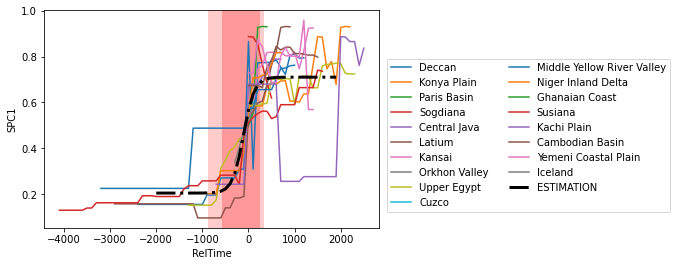

In [68]:
DF_Out_cutout = pd.DataFrame(columns=["NGA","RelTime","SPC1"])

for N in list(set(Cutout_DF["NGA"])):
    DF = Cutout_DF[Cutout_DF["NGA"] == N]
    plt.plot(DF["RelTime"],   
             DF["SPC1"], label=N)
    DF_Out_cutout = pd.concat((DF_Out_cutout, DF[["NGA", "RelTime", "SPC1"]]))
    #print(N)
    
plt.plot(TimeRange, New_Fit, "-.",label="ESTIMATION", c = "k", linewidth=3)
plt.legend(bbox_to_anchor=(1.01, 0.8), ncol=2)
plt.ylabel("SPC1")
plt.xlabel("RelTime")
plt.axvspan(T1_scaled, T2_scaled, facecolor='r', alpha=0.4)
plt.axvspan(T2_scaled, T2_end_scaled, facecolor='r', alpha=0.2)
plt.axvspan(T1_start_scaled, T1_scaled, facecolor='r', alpha=0.2)
plt.savefig("SPC1_Time_Interval_Cutouts")
plt.show()

In [71]:
Cutout_CCDF.index = np.arange(0,len(Cutout_CCDF["NGA"]))
Cutout_CCDF.to_csv("Cutouts_CC_with_Reltime.csv")